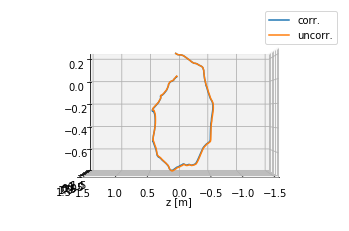

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os import walk, path
import csv

currentDir = "./data/Samsung/1603112728744/"
uncorrected = "rgbMetaData.csv"
corrected = "anchors.csv"

# load all filenames
f = []
for (dirpath, dirnames, filenames) in walk(currentDir):
    f.extend(filenames)
    break

# map all timestamps from filenames to list
tsColor = list(map(lambda x: int(path.splitext(x)[0]), filter(lambda k: '.jpg' in k, f)))
tsDepth = list(map(lambda x: int(path.splitext(x)[0]), filter(lambda k: '.bin' in k, f)))

# Depth Image Size
imgSize = (640,480)

# Intrinsics Depth Camera
fxD = 548.6746
fyD = 548.2399
cxD = 328.471
cyD = 227.87173

# Intrinsics Color Camera
fxC = 500.13434
fyC = 498.4431
cxC = 319.90588
cyC = 241.57094


# Plot Config
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('x [m]')
plt.xlabel('y [m]')
plt.xlabel('z [m]')

def drawTrajectory(filename, label):
    with open(filename) as csvfile:  
        data = csv.reader(csvfile, delimiter=";")
        numRows = len(list(data))
        t = np.zeros((numRows-1,3))
        csvfile.seek(0)
        header = next(data)
        idx = header.index("CAMERA_FRAME_TRANSLATION")
        for i, row in enumerate(data):
            t[i,:] = row[idx].replace("[","").replace("]","").split(",") 

    ax.plot(t[:,0], t[:,1], t[:,2], label = label)
    csvfile.close()

drawTrajectory(currentDir + corrected, "corr.")
drawTrajectory(currentDir + uncorrected, "uncorr.")
plt.legend()
ax.view_init(0,90)


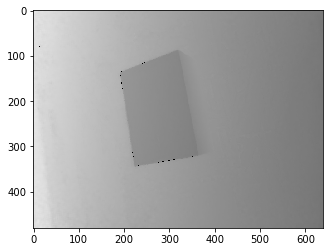

In [7]:
# Save binary depth file to PNG
import cv2
from PIL import Image
import struct


depth16 = np.fromfile(currentDir + str(tsDepth[0]) + ".bin", dtype=np.uint16)
def extractDepth(x):
    confidence = (x >> 13) & 0x7 # extracting confidence bits
    if (confidence > 6): return 0 # filter depth by confidence (0 => highest confidence, 7 => lowest confidence)
    return x & 0x1FFF # eliminating confidence bits
depth = np.array([extractDepth(x) for x in depth16]).reshape(imgSize[1],imgSize[0])
depthImg = np.array([(x / 4).astype(np.uint8) for x in depth])
cv2.imwrite("depth.png", depthImg)
plt.imshow(cv2.cvtColor(depthImg, cv2.COLOR_GRAY2BGR))
plt.show()

In [8]:
# Convert depth image to 3D Pointcloud and save it as PLY file

# define of PLY header
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
end_header
'''

points = np.zeros((depth.shape[0],depth.shape[1],3))
for v in range(depth.shape[0]):
    for u in range(depth.shape[1]):
        Z = float(depth[v,u]) 
        if Z==0: continue
        X = (u - cxD) * Z / fxD
        Y = (v - cyD) * Z / fyD
        points[v,u,:] = np.array([X,Y,Z])

mask_map = depth > depth.min()
output_points = points[mask_map]

def write_ply(fn, verts):
    verts = verts.reshape(-1, 3)
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f')

write_ply("test.ply", output_points)
print("written")

written


In [10]:
### Map color to 3D pointcloud ###

from scipy.spatial.transform import Rotation as R
from scipy.linalg import *

# define PLY header with BGR channels
ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar blue
		property uchar green
		property uchar red
		end_header
		'''

# color camera LENS_POSE_ROTATION quaternion in world frame
R_Cw = R.from_quat([0.7071, -0.7071, 0.0, 0.0])

# depth camera LENS_POSE_ROTATION quaternion in world frame
R_Dw = R.from_quat([0.70603824, -0.7081175, 0.0067449044, -0.003860426])

# calculate rotation from depth camera to color camera
e1 = np.array([1,0,0]) # define unit vector
e2 = R_Cw.apply(e1) # get new rotated unit vector e2 with color camera rotation
e2 = R_Dw.apply(e2,True) # rotate unit vector e2 back to with depth camera rotation

R_Dc = R
R_Dc,rmsd = R_Dc.align_vectors([e2],[e1]) # get Rotation from between both vectors e1,e2
R_Dc = R_Dc.inv()

print(R_Dc.as_quat())

# DEPTH CAMERA TRANSLATION TO SENSOR FRAME
T_Dc = np.array([-0.011347568,0.0017709293,-0.0]) * 1000
T_Dc = R_Cw.apply(T_Dc)
print(T_Dc)

# rotation and translation to homogenous transformation
H_Dc = np.zeros((3,4))
H_Dc[:,0:3] = R_Dc.as_matrix()
H_Dc[:,3] = T_Dc

# load color image
colors = cv2.imread(currentDir + str(tsColor[0]) + ".jpg")
resized = cv2.resize(colors, imgSize, interpolation = cv2.INTER_AREA) 
rows,cols,channels = resized.shape

p_h = np.ones(4)
print(p_h)

output_colors = np.zeros(output_points.shape)

for i in range(output_points.shape[0]):
    p_h[0:3] = output_points[i,:]
    p = H_Dc.dot(p_h)
    u = int(fxC * p[0]/p[2] + cxC)
    v = int(fyC * p[1]/p[2] + cyC)
    if (v < resized.shape[0] and u < resized.shape[1]):
        output_colors[i] = resized[v,u,:]


def create_output(vertices, output_colors, filename):
	output_colors = output_colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),output_colors])
	
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

fileName = "colored_pointcloud.ply"
create_output(output_points, output_colors, fileName)
print(fileName +  " written")


[ 0.         -0.00205062 -0.00145494 -0.99999684]
[-1.7709293 11.347568   0.       ]
[1. 1. 1. 1.]
colored_pointcloud.ply written


In [11]:
# parse SLAM trajectory
def parseTransformation(filename, label, dim):
    with open(filename) as csvfile: 
        data = csv.reader(csvfile, delimiter=";")
        numRows = len(list(data))
        t = np.zeros((numRows-1,dim))
        csvfile.seek(0)
        header = next(data)
        idx = header.index(label)
        for i, row in enumerate(data):
            t[i] = list(map(lambda x: float(x), row[idx].replace("[","").replace("]","").split(",")))
    csvfile.close()
    return t

# initialize transformation matrix in homogeneous coordinates
H_Cw = np.zeros((3,4)) 
# get camera translation in world frame
T_C = parseTransformation(currentDir + corrected, "CAMERA_FRAME_TRANSLATION", 3) * 1000
# get camera rotation in world frame
R_C = parseTransformation(currentDir + corrected, "CAMERA_FRAME_ROTATION", 4)
# Rotation ARCore to OpenGL
R_OGL = R.from_quat([1,0,0,0]) 

# returns index of the closest number in a list
def closest(lst, K): 
    return min(range(len(lst)), key = lambda i: abs(lst[i]-K))

# define used sample Idexes
sampleIdxs = np.linspace(0, len(tsDepth)-1, min(7, len(tsDepth)), endpoint=True, dtype=int)

def create_output(vertices, output_colors, filename):
	output_colors = output_colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),output_colors])
	
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

# iterate through chosen samples
for idx in range(len(sampleIdxs)): 
    # depth image timestamp
    print("depth image ts: " + str(tsDepth[sampleIdxs[idx]]))
    fileName = currentDir + str(tsDepth[sampleIdxs[idx]]) + ".bin"
    # load DEPTH16 binary file
    depth16 = np.fromfile(fileName, dtype=np.uint16)
    # get depth from binary data
    depth = np.array([extractDepth(x) for x in depth16]).reshape(imgSize[1],imgSize[0])

    # initialize point and color arrays
    points = np.zeros((depth.shape[0],depth.shape[1],3))
    colors = np.zeros(points.shape)

    # get closest camera image timestamp
    tIdx = closest(tsColor, tsDepth[sampleIdxs[idx]])
    print("color image ts: " + str(tsColor[tIdx]))
    print(str((tsColor[tIdx]-tsDepth[sampleIdxs[idx]])/1000000) + " ms difference")

    # fill rotation matrix into transformation matrix
    H_Cw[:,0:3] = (R.from_quat(R_C[tIdx,:]).as_matrix()) 
    # fill translation vector into transformation matrix
    H_Cw[:,3] = T_C[tIdx]

    # load camera image
    bgr = cv2.imread(currentDir + str(tsColor[tIdx]) + ".jpg")

    for v in range(depth.shape[0]):
        for u in range(depth.shape[1]):
            Z = float(depth[v,u]) 
            if Z==0.0: continue
            X = (u - cxD) * Z / fxD
            Y = (v - cyD) * Z / fyD
            Pd = H_Dc.dot(np.array([X,Y,Z,1])) # apply transformation from depth frame to camera frame
            uc = int(fxC * Pd[0]/Pd[2] + cxC) # map 3D points to color pixels
            vc = int(fyC * Pd[1]/Pd[2] + cyC)
            if (vc >= bgr.shape[0] or uc >= bgr.shape[1]): 
                depth[v,u] = 0
                continue
            colors[v,u,:] = bgr[vc,uc,:]
            Pc = R_OGL.apply(Pd) # rotate to Open GL coordinate system around x-axis
            points[v,u,:] = H_Cw.dot(np.array([Pc[0],Pc[1],Pc[2],1]))

    mask_map = depth > 0
    output_points = points[mask_map]
    output_colors = colors[mask_map]

    create_output(output_points, output_colors, "test" + str(idx) + ".ply")
    print("written")    







depth image ts: 5501130290085
color image ts: 5501232195664
101.905579 ms difference
written
depth image ts: 5506372840735
color image ts: 5506364377861
-8.462874 ms difference
written
depth image ts: 5511077698616
color image ts: 5511063682645
-14.015971 ms difference
written
depth image ts: 5516891559689
color image ts: 5516896532933
4.973244 ms difference
written
depth image ts: 5521293957878
color image ts: 5521295659937
1.702059 ms difference
written
depth image ts: 5525931602375
color image ts: 5525928661682
-2.940693 ms difference
written
depth image ts: 5531006125256
color image ts: 5530994824803
-11.300453 ms difference
written
